## TRY DOC TO VEC ON SOME TWEETS 
---

In the end, results aren't really good, mostly because input data is short (small phrases) and not numerous (in number of training samples). 






In [101]:
import pandas as pd

#Load the dataset and explore.
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/train_data.csv
    !ls -lah DATAPATH
    filepath = "DATAPATH/train_data.csv"
except ModuleNotFoundError:
    filepath = "Data/Sentiment and Emotion in Text/train_data.csv"

--2021-07-20 06:44:02--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/train_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2479133 (2.4M) [text/plain]
Saving to: ‘DATAPATH/train_data.csv.1’

train_data.csv.1    100%[===================>]   2.36M  --.-KB/s    in 0.03s   

2021-07-20 06:44:02 (84.7 MB/s) - ‘DATAPATH/train_data.csv.1’ saved [2479133/2479133]

--2021-07-20 06:44:03--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Sentiment%20and%20Emotion%20in%20Text/test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.github

In [102]:
# READ CSV ------
df = pd.read_csv(filepath)
print(df.shape)
print(df.head())
print(df.tail())

(30000, 2)
    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...
       sentiment                                            content
29995  happiness  I had a great date last night...tried to find ...
29996    sadness                                          With alex
29997  happiness  @fureousangel that is comedy  good luck my fri...
29998        fun  stephs grad party gr8! shoved cake in her face...
29999  happiness  @jesfive SWEEEEET - San Fran is awesome!!!!  L...


The data comes from https://www.kaggle.com/c/sa-emotions/data. 

The database has several sentiments that should be infer by the content of tweet text. 
The dataset is not balanced. 

In [103]:
# SENTIMENTS ------
print(df['sentiment'].value_counts())
print("Number of sentiments in target:", len(df['sentiment'].value_counts()))

worry         7433
neutral       6340
sadness       4828
happiness     2986
love          2068
surprise      1613
hate          1187
fun           1088
relief        1021
empty          659
enthusiasm     522
boredom        157
anger           98
Name: sentiment, dtype: int64
Number of sentiments in target: 13


Although there are a lot of sentiments (13).  We subset the data to only retain 3 of them: neutral, happiness, worry. These 3 categories are well represented in the data set.

Happiness is the the most common positive feeling. 

Worry is the most common negative feeling.

In [104]:
# SUBSET SENTIMENTS ------
#Let us take the top 3 categories and leave out the rest.
shortlist = ['neutral', "happiness", "worry"]
df_subset = df[df['sentiment'].isin(shortlist)]
# Which gives us this shape
df_subset.shape

(16759, 2)

## Treat Tweets as documents
This time we will infer the emotion thanks to the whole tweet, by infering the document embedding

### Tokenize the tweets!

In [105]:
# We should import some nlp libraries ---
import nltk 
import spacy, re
from sklearn.model_selection import train_test_split
# DL NLP LIB ---
!pip install --upgrade gensim
import gensim
print(gensim.__version__)
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

# Stopwords ---
nltk.download('stopwords') # Stopwords to remove
stop_words = [w.lower() for w in nltk.corpus.stopwords.words()]
# Initiate spacy ---
nlp = spacy.load('en')
# Tokenize tweets FUN ---
  # I found a clean function in stackoverflow. 
  # Does the job well
def clean(input_string):
    """ Sanitize one string """

    # normalize to lowercase 
    string = input_string.lower()

    # spacy tokenizer 
    string_split = [token.text for token in nlp(string)]

    # in case the string is empty 
    if not string_split:
        return '' 

    # remove user 
    # assuming user is the first word and contains an @
    if '@' in string_split[0]:
        del string_split[0]

    # join back to string 
    #string = ' '.join(string_split)

    #remove # and @
    def special(string): 
      for punc in '@#':
        return(string.replace(punc, ''))
    
    list_string= [special(i) for i in string_split]

    # remove 't.co/' links
    list_string = [re.sub(r't.co\/[^\s]+', '', i, flags=re.MULTILINE) for i in list_string]

    # removing stop words 
    list_string = [w for w in list_string if w not in stop_words]

    return list_string 

4.0.1
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We know apply the function to each row. Each document is tokenized and also preprocessed (spaces, hashtags, stopwords...).

This take a little while. 

In [106]:
# APLLY FUN TO CLEAN DOCUMENTS ------
df_subset["content"]=df_subset.content.apply(clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Know we can separate our data into training and testing sets. Kaggle has a testing set but since we subset only a fraction of the sentiments, it's possible that we won't see good results. Although we should be able to distinguish negative, positive and neutral overall. 

In [107]:
# SEPARATE DATA -----
#df_subset contains only the three categories we chose. 
mydata = df_subset['content']
mycats = df_subset['sentiment']
# TRAIN TEST SPLIT ------
train_data, test_data, train_cats, test_cats = train_test_split(mydata,mycats,random_state=1234)

Gensim's Doc2vec documentation explains that each document should be of class TaggedDocument. That is, every document has to have 2 parts: text and tags. It is common that the tag is just an integer index that increases by one step each row. 

In [108]:
# DOC2VEC format ------
#prepare training data in doc2vec format:
train_doc2vec = [TaggedDocument((d), tags=[str(i)]) for i, d in enumerate(train_data)]

Let's take a look: 

In [109]:
# First 5 taggedDocuments ---
train_doc2vec[0:5]

[TaggedDocument(words=["caaaaan't", 'sleep', '.....', "'s", '3.30am', '!', 'wahhhh', '...', 'wanna', 'cry'], tags=['0']),
 TaggedDocument(words=['based', 'future', 'forgetting', '/', 'ignoring', ' ', 'present', ',', 'best', 'keeper', 'according', 'dhoni', 'parthiv'], tags=['1']),
 TaggedDocument(words=['good', 'morning', '!', ' ', 'early', 'bad', 'conscience', ',', 'trying', 'make', 'taking', 'day', 'yesterday', ',', '?', ':p'], tags=['2']),
 TaggedDocument(words=['hahaha', 'chivalry', "'s", 'dead', ',', 'rare'], tags=['3']),
 TaggedDocument(words=['joining', 'twitter'], tags=['4'])]

In [110]:
# first 5 sentiments --- 
train_cats[0:5]

1953         worry
25364      neutral
20925        worry
5221     happiness
20542      neutral
Name: sentiment, dtype: object

### Train the unsupervised model  

Know we will fit the model on our documents. 

The embedding space of each document will be 50, with an learning rate of 0.025. This rate will decrease until 0.05.

We remove some common words (in the sense of high frequency) : the stopwrods. But we didn't remove unfrequent words that are less likely to appear in our testing corpus or other documents. We define min_count to 10.  

We also precise dm = 0 to use the PV-DBOW implementation of the algorithm. This algorithm will input at each step the document embedding and the BOW embeddings (concatenation: dm_concat= 1) to predict a centric word. In the end, we get the word embedding and document embeddings. 

Documents that are used in similar context, predicting similar words, concatenated with similar context will be closer in the embedding space.  

We also specify the number of negative sampled documents for the loss function. At each time our word (target) activation will be compared to 20 other words activations with current weights instead of the whole vocabulary. This leads to faster training times.

In [111]:
# I like the output from logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#Train a doc2vec model to learn tweet representations. Use only training data!!
model = Doc2Vec(vector_size=50, alpha=0.025,  min_alpha=0.05, min_count=10, dm =0,dbow_words=1, negative= 20,dm_concat=1, workers=2, epochs=150)
# Build the vocabulary ---
model.build_vocab(train_doc2vec)
# Check BOW method ---
print("DBOW method:", model.dbow)
print("Number of documents:", model.corpus_count)
print("Size of vocab", model.corpus_total_words)

2021-07-20 06:47:48,465 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dbow+w,d50,n20,w5,mc10,s0.001,t2)', 'datetime': '2021-07-20T06:47:48.465471', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-07-20 06:47:48,468 : INFO : collecting all words and their counts
2021-07-20 06:47:48,469 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-07-20 06:47:48,531 : INFO : PROGRESS: at example #10000, processed 94745 words (1562192/s), 14302 word types, 10000 tags
2021-07-20 06:47:48,628 : INFO : collected 16589 word types and 12569 unique tags from a corpus of 12569 examples and 119293 words
2021-07-20 06:47:48,629 : INFO : Creating a fresh vocabulary
2021-07-20 06:47:48,645 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1308 unique words (7.884742901922961%% of original 16589, drops 15281)', 'datetime': '2

DBOW method: 1
Number of documents: 12569
Size of vocab 119293


In [112]:
# TRAIN MODEL ------
model.train(train_doc2vec, total_examples=model.corpus_count, epochs=model.epochs)

2021-07-20 06:52:24,377 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 2 workers on 1309 vocabulary and 50 features, using sg=1 hs=0 sample=0.001 negative=20 window=5', 'datetime': '2021-07-20T06:52:24.377131', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-07-20 06:52:25,464 : INFO : EPOCH 1 - PROGRESS: at 92.27% examples, 65513 words/s, in_qsize 1, out_qsize 1
2021-07-20 06:52:25,466 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-20 06:52:25,476 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-20 06:52:25,477 : INFO : EPOCH - 1 : training on 119293 raw words (76259 effective words) took 1.1s, 70232 effective words/s
2021-07-20 06:52:26,543 : INFO : EPOCH 2 - PROGRESS: at 91.68% examples, 66606 words/s, in_qsize 1, out_qsize 1
2021-07-20 06:52:26,544 : INFO : worker thread finished; awaiting fin

There is no implementation of history loss in gensim's Doc2Vec. Sadly this is only a feature that Word2Vec has. So we don't know if 100 epochs was leading to overfitting, it probably did.

Let's save the model. 

In [113]:
model.save("emotionsdoc2vec.model")

2021-07-20 06:55:05,282 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'emotionsdoc2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-07-20T06:55:05.282790', 'gensim': '4.0.1', 'python': '3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-07-20 06:55:05,285 : INFO : not storing attribute cum_table
2021-07-20 06:55:05,301 : INFO : saved emotionsdoc2vec.model


Let's see if we can separate the documents using only the embeddings distance. 

In [114]:
# Extract the embeddings ---
dv = [model.dv[i] for i in range(len(model.dv))]

In [115]:
# Logical indexing vectors ---
neutral = (train_cats=="neutral").values
neg = (train_cats=="worry").values
pos = (train_cats=="happiness").values

# We need to subset the list with boolean values
from itertools import compress

# Subset document embeddings ---
neutral= list(compress(dv, neutral))
neg= list(compress(dv, neg))
pos= list(compress(dv, pos))

Now that we have the embeddings we can calculate the similarity scores. 
In sklearn, if we only provide X, the cosine similarity is calculated between all elements of X, returning a matrix of shape (len(X), len(X)).

In [116]:
from sklearn.metrics.pairwise import cosine_similarity

In [117]:
# Calculate cosine similarity ---
neutral_scores=cosine_similarity(neutral)
neg_scores=cosine_similarity(neg)
pos_scores=cosine_similarity(pos)
# Calculate Mean scores  ---
neutral_scores_mean=neutral_scores.mean()
neg_scores_mean=neg_scores.mean()
pos_scores_mean=pos_scores.mean()
# Print --- 
print("Neutral with itself:", neutral_scores_mean)
print("Negative with itself:", neg_scores_mean)
print("Positive with itself:", pos_scores_mean)

Neutral with itself: 0.20374197
Negative with itself: 0.19797114
Positive with itself: 0.21294023


We obtained low mean cosine similarities between the elements of each category. That is, neutral documents are close to other neutral documents in average, the same goes to the other 2 categories. 

Also, the average intra-class distance is similar between classes. Although, on average, neutral documents are farther away with other neutral documents than positive ones with other positive documents. 

We can calculate now the similarities between classes: Neutral to both neg and pos and also the similarity between pos and neg.

In [118]:
# Calculate cosine similarity ---
neutral_neg_scores=cosine_similarity(neutral, neg)
neutral_pos_scores=cosine_similarity(neutral, pos)
neg_pos_scores=cosine_similarity(neg, pos)
# Print shapes 
print(neutral_neg_scores.shape)
print(neutral_pos_scores.shape)
print(neg_pos_scores.shape)
# Calculate Mean scores  ---
neutral_neg_scores_mean=neutral_neg_scores.mean()
neutral_pos_scores_mean=neutral_pos_scores.mean()
neg_pos_scores_mean=neg_pos_scores.mean()
# Print --- 
print("Neutral with Negative:", neutral_neg_scores_mean)
print("Neutral with Positive:", neutral_pos_scores_mean)
print("Negative with Positive:", neg_pos_scores_mean)

(4745, 5551)
(4745, 2273)
(5551, 2273)
Neutral with Negative: 0.19776234
Neutral with Positive: 0.19995604
Negative with Positive: 0.19293462


Sadly, there is some noise in the averages. We do not get very good results only comparing cosine distances averages between classes. 

Let's fit a classifier. 

I'll use a multi-variable logistic regression trained on the training set embeddings and classes. The logistic regression will then be used with the testing set in two parts: first, infer the document embeddings, second, infer the class.

In [119]:
from sklearn.linear_model import LogisticRegression

log_reg= LogisticRegression(class_weight="balanced")
log_reg.fit(dv,train_cats)
log_reg.score(dv, train_cats) # accuracy 

0.5212825204869123

In [121]:
# Predict on testing data ------
  # Infer embedding ---
dv_test= [model.infer_vector(element, steps=100) for element in test_data]
  # Infer class --- 
preds=log_reg.predict(dv_test)

In [124]:
from sklearn.metrics import classification_report
print(classification_report(test_cats, preds))

              precision    recall  f1-score   support

   happiness       0.36      0.49      0.41       713
     neutral       0.49      0.61      0.54      1595
       worry       0.64      0.42      0.51      1882

    accuracy                           0.50      4190
   macro avg       0.50      0.51      0.49      4190
weighted avg       0.53      0.50      0.50      4190



If we try some dimensionality reduction maybe it'll help our classifier.  

In [133]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
data = pca.fit_transform(dv)

In [134]:
log_reg= LogisticRegression(class_weight="balanced")
log_reg.fit(data,train_cats)
log_reg.score(data, train_cats) # accuracy 

0.4577929827353011

In [136]:
component_data= pd.DataFrame(data, columns= ["comp1","comp2","comp3","comp4"])
component_data["true_label"]= train_cats.values

2021-07-20 07:11:30,545 : INFO : NumExpr defaulting to 2 threads.


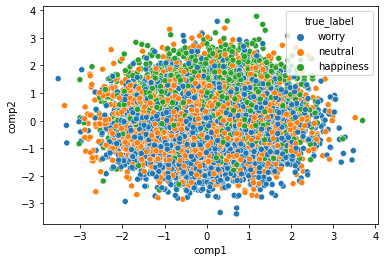

In [143]:
import seaborn as sns
sns.scatterplot(data=component_data, x='comp1', y='comp2', hue='true_label')

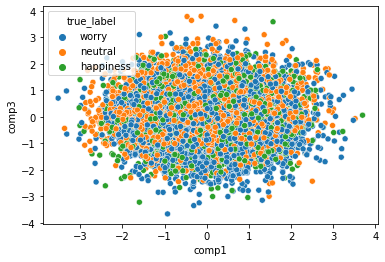

In [144]:
sns.scatterplot(data=component_data, x='comp1', y='comp3', hue='true_label')

Okay in this case our approach failed. Nonetheless, it is normal, not every attempt can work. Still it is good practice to try gensim's doc2vec. 
